In [ ]:
#downloading data & code in folder of this notebook
!git clone https://github.com/rindhane/DataMusings tmp
%cd ./tmp

In [ ]:
!pip install -r requirements.txt

## CRISP-DM 
 [CRIS-PDM](https://en.wikipedia.org/wiki/Cross-industry_standard_process_for_data_mining) process has been followed to evaluate the strategy of renting a room for house owner in Boston Area.

*Step 1:*
### Business Understanding

Airbnb provides services for home owners to connect to tourists to stay in their home for some chargeable fee.
So for a home owner it is crucial to understand the right pricing and positioning of its rented space in the available market. 

So here, our focus is to answer following questions on current data from Airbnb in perspective of Home Owners : 

1. What is average earning potential for a room within a given city ? 
3. What is the range of price for a room ?
2. Is the demand consitent throughout the year ? 
4. What are 3 major factors that influence the asking price for a room/ rented space inorder to increas the ask price ? 


In [3]:
#loading the data for inspection.
from downloader import get_data
from datetime import datetime
city="Boston"
df_dict=get_data(city=city, 
                latest_by=datetime.today().strftime("%d-%B-%Y"))
listings=df_dict['listings'];calendar=df_dict['calendar'];reviews=df_dict['reviews']

*Step 2:*
### Data Understanding  
Let's deep dive down on the data from csv files available on this [url](http://insideairbnb.com/get-the-data.html) 

*Remarks*: 
- Initial focus and Exploratory analysis is for City 'Boston' to create a template which can be later on applied for any city from their respective data.
- Keeping analysis focused on a city stems from the logic that the tourism demands vary from city to city. But within city , the option of stay is largely dependent on the choice of the tourist.     



### Data available :
There are 4 sets of data available viz : 
 - **listings.csv.gz/ listings.csv** : This data set shows characteristics like price, listing's location, host details etc.. related to each individual listing in a standard row-column format. rows are each individual listings and columns are the features of that listing.
 - **calendar.csv.gz/ calendar.csv** : This data set shows for each listing the price for booking for each available night from the scraped date till next 365 days.   
 - **review.csv.gz/ review.csv.gz** : This data set displays all the review comments till the scraped date and and its corresponding dates for each individual listings.  

**Note** : 
1. *.csv* vs *.csv.gz* | .csv are summary version while csv.gz is the compressed containing all the header columns. 

First let's checkout the listings.csv.gz

In [4]:
listings.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'description',
       'neighborhood_overview', 'picture_url', 'host_id', 'host_url',
       'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'calendar_upd

In [5]:
listings.describe()

,id,scrape_id,host_id,host_listings_count,host_total_listings_count,neighbourhood_group_cleansed,latitude,longitude,accommodates,bathrooms,bedrooms,beds,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
count,3.236000e+03,3.236000e+03,3.236000e+03,3236.000000,3236.000000,0.0,3236.000000,3236.000000,3236.000000,0.0,2866.000000,3217.000000,3236.000000,3236.000000,3235.000000,3235.000000,3235.000000,3.235000e+03,3235.000000,3.235000e+03,0.0,3236.000000,3236.000000,3236.000000,3236.000000,3236.000000,3236.000000,3236.000000,2348.000000,2345.000000,2346.000000,2344.000000,2347.000000,2345.000000,2345.000000,3236.000000,3236.000000,3236.000000,3236.000000,2366.000000
mean,2.763080e+07,2.020111e+13,1.068949e+08,164.263288,164.263288,NaN,42.337505,-71.082813,3.129790,NaN,1.437195,1.686043,37.860321,787.837454,39.415147,58.433694,883.762597,1.328546e+06,56.353663,1.325540e+06,NaN,13.764524,31.863721,52.328183,194.450247,38.229295,5.845488,0.569221,93.551959,9.597441,9.488491,9.753413,9.703025,9.600853,9.281876,23.270087,19.514215,3.691595,0.004635,1.561306
std,1.424403e+07,0.000000e+00,1.150931e+08,405.546140,405.546140,NaN,0.026370,0.032670,2.082197,NaN,0.834089,1.315912,45.723769,476.449872,66.608242,122.318861,435.655428,5.338760e+07,119.372472,5.326681e+07,NaN,12.714467,24.773140,36.111828,137.587297,68.241660,12.698559,2.210659,8.657687,0.866514,0.902068,0.761727,0.791043,0.766847,0.961432,37.937433,37.393386,8.091865,0.067936,2.117761
min,3.781000e+03,2.020111e+13,4.804000e+03,0.000000,0.000000,NaN,42.235200,-71.172130,1.000000,NaN,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000e+00,1.000000,1.000000e+00,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,20.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.000000,0.000000,0.000000,0.000000,0.010000
25%,1.540728e+07,2.020111e+13,1.594356e+07,1.000000,1.000000,NaN,42.321400,-71.102780,2.000000,NaN,1.000000,1.000000,2.000000,365.000000,2.000000,3.000000,365.000000,3.650000e+02,2.000000,3.650000e+02,NaN,0.000000,0.000000,7.000000,72.750000,0.000000,0.000000,0.000000,91.000000,9.000000,9.000000,10.000000,10.000000,9.000000,9.000000,1.000000,0.000000,0.000000,0.000000,0.270000
50%,2.935600e+07,2.020111e+13,4.677445e+07,5.000000,5.000000,NaN,42.344840,-71.073050,2.000000,NaN,1.000000,1.000000,28.000000,1125.000000,21.000000,28.000000,1125.000000,1.125000e+03,28.000000,1.125000e+03,NaN,12.000000,38.000000,65.000000,180.000000,7.000000,1.000000,0.000000,96.000000,10.000000,10.000000,10.000000,10.000000,10.000000,9.000000,5.000000,1.000000,0.000000,0.000000,0.930000
75%,4.141947e+07,2.020111e+13,2.011787e+08,37.000000,37.000000,NaN,42.354080,-71.060888,4.000000,NaN,2.000000,2.000000,91.000000,1125.000000,91.000000,91.000000,1125.000000,1.125000e+03,91.000000,1.125000e+03,NaN,29.000000,58.000000,88.000000,344.000000,43.000000,6.000000,0.000000,99.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,29.000000,20.000000,3.000000,0.000000,2.210000
max,4.633063e+07,2.020111e+13,3.736751e+08,1515.000000,1515.000000,NaN,42.390670,-70.997010,16.000000,NaN,13.000000,22.000000,1000.000000,9999.000000,1000.000000,1000.000000,9999.000000,2.147484e+09,1000.000000,2.142625e+09,NaN,30.000000,60.000000,90.000000,365.000000,571.000000,250.000000,80.000000,100.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,155.000000,155.0000

Listing data has 74 columns , in which some have textual information and some have quantitative data. Let's segment this factors into relevant group to make our analysis simple. 

In [6]:
listing_identifiers= ['id','listing_url', 'scrape_id', 'last_scraped','calendar_last_scraped',
                      'first_review','last_review',]
listing_qualitative_factors = ['name', 'description','neighborhood_overview', 'picture_url','latitude', 
                               'longitude','calendar_updated','reviews_per_month']
listing_characterisitics = [ 'neighbourhood','neighbourhood_cleansed',
                                'neighbourhood_group_cleansed','property_type','room_type', 
                                'accommodates', 'bathrooms_text','bathrooms', 'bedrooms', 'beds',
        'amenities','has_availability',
        'availability_30', 'availability_60', 'availability_90',
        'availability_365','minimum_nights', 'maximum_nights',
        'minimum_minimum_nights', 'maximum_minimum_nights',
        'minimum_maximum_nights', 'maximum_maximum_nights',
        'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm',]
host_details = ['host_id','host_url','host_name', 'host_since', 'host_location', 
                    'host_about', 'host_thumbnail_url', 'host_picture_url','host_neighbourhood',
                    'host_listings_count','host_total_listings_count','host_has_profile_pic',]
host_performance_parameters= ['host_response_time', 'host_response_rate', 
                                'host_acceptance_rate', 'host_verifications',
                                'host_identity_verified','host_is_superhost']
earning_estimators=['price','number_of_reviews','number_of_reviews_ltm', 
                            'number_of_reviews_l30d',]
earning_influencers=['review_scores_rating', 'review_scores_accuracy',
        'review_scores_cleanliness', 'review_scores_checkin',
        'review_scores_communication', 'review_scores_location',
        'review_scores_value','license', 'instant_bookable',]
host_other_details= ['calculated_host_listings_count',
        'calculated_host_listings_count_entire_homes',
        'calculated_host_listings_count_private_rooms',
        'calculated_host_listings_count_shared_rooms',]


* let's further inspect them : 


In [7]:
listings[listing_identifiers].head()

,id,listing_url,scrape_id,last_scraped,calendar_last_scraped,first_review,last_review
0,3781,https://www.airbnb.com/rooms/3781,20201110041432,2020-11-10,2020-11-10,2015-07-10,2020-09-03
1,5506,https://www.airbnb.com/rooms/5506,20201110041432,2020-11-10,2020-11-10,2009-03-21,2020-05-01
2,6695,https://www.airbnb.com/rooms/6695,20201110041432,2020-11-10,2020-11-10,2009-08-06,2019-11-02
3,10730,https://www.airbnb.com/rooms/10730,20201110041432,2020-11-10,2020-11-10,2009-09-21,2020-04-16
4,10813,https://www.airbnb.com/rooms/10813,20201110041432,2020-11-10,2020-11-10,2019-12-12,2020-03-08


In [8]:
listings[listing_qualitative_factors].head()

,name,description,neighborhood_overview,picture_url,latitude,longitude,calendar_updated,reviews_per_month
0,HARBORSIDE-Walk to subway,Fully separate apartment in a two apartment bu...,"Mostly quiet ( no loud music, no crowed sidewa...",https://a0.muscache.com/pictures/24670/b2de044...,42.36413,-71.02991,NaN,0.26
1,**$49 Special ** Private! Minutes to center!,"Private guest room with private bath, You do n...","Peacful, Architecturally interesting, historic...",https://a0.muscache.com/pictures/1598e8b6-5a55...,42.32981,-71.09559,NaN,0.75
2,$99 Special!! Home Away! Condo,"Comfortable, Fully Equipped private apartment...","Peaceful, Architecturally interesting, histori...",https://a0.muscache.com/pictures/38ac4797-e7a4...,42.32994,-71.09351,NaN,0.84
3,Bright 1bed facing Golden Dome,"Bright, spacious unit, new galley kitchen, new...",Beacon Hill is located downtown and is conveni...,https://a0.muscache.com/pictures/miso/Hosting-...,42.35840,-71.06185,NaN,0.24
4,"Back Bay Apt-blocks to subway, Newbury St, The...",Stunning Back Bay furnished studio apartment. ...,Wander around this quintessential neighborhood...,https://a0.muscache.com/pictures/20b5b9c9-e1f4...,42.35061,-71.08787,NaN,0.90


In [9]:
listings[listing_characterisitics].head()

,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,property_type,room_type,accommodates,bathrooms_text,bathrooms,bedrooms,beds,amenities,has_availability,availability_30,availability_60,availability_90,availability_365,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm
0,"Boston, Massachusetts, United States",East Boston,NaN,Entire apartment,Entire home/apt,2,1 bath,NaN,1.0,0.0,"[""Washer"", ""Kitchen"", ""Hair dryer"", ""Laptop-fr...",t,0,20,50,140,28,1125,28.0,28.0,1125.0,1125.0,28.0,1125.0
1,"Boston, Massachusetts, United States",Roxbury,NaN,Entire guest suite,Entire home/apt,2,1 bath,NaN,1.0,1.0,"[""Luggage dropoff allowed"", ""Washer"", ""Keypad""...",t,0,0,0,0,3,730,3.0,3.0,730.0,730.0,3.0,730.0
2,"Boston, Massachusetts, United States",Roxbury,NaN,Entire condominium,Entire home/apt,4,1 bath,NaN,1.0,1.0,"[""Luggage dropoff allowed"", ""Washer"", ""Kitchen...",t,0,0,0,0,3,730,3.0,3.0,730.0,730.0,3.0,730.0
3,"Boston, Massachusetts, United States",Downtown,NaN,Entire apartment,Entire home/apt,2,1 bath,NaN,1.0,1.0,"[""Washer"", ""Kitchen"", ""Hair dryer"", ""Laptop-fr...",t,0,0,23,298,91,365,91.0,91.0,365.0,365.0,91.0,365.0
4,"Boston, Massachusetts, United States",Back Bay,NaN,Entire apartment,Entire home/apt,3,1 bath,NaN,NaN,1.0,"[""Kitchen"", ""Hair dryer"", ""Laptop-friendly wor...",t,0,0,0,0,28,1125,28.0,28.0,1125.0,1125.0,28.0,1125.0


In [10]:
listings[host_details].head()

,host_id,host_url,host_name,host_since,host_location,host_about,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_has_profile_pic
0,4804,https://www.airbnb.com/users/show/4804,Frank,2008-12-03,Massachusetts,My wife and I and grown children frequently oc...,https://a0.muscache.com/im/users/4804/profile_...,https://a0.muscache.com/im/users/4804/profile_...,East Boston,5,5,t
1,8229,https://www.airbnb.com/users/show/8229,Terry,2009-02-19,"Boston, Massachusetts, United States","Relaxed, Easy going, Accommodating.",https://a0.muscache.com/im/users/8229/profile_...,https://a0.muscache.com/im/users/8229/profile_...,Roxbury,2,2,t
2,8229,https://www.airbnb.com/users/show/8229,Terry,2009-02-19,"Boston, Massachusetts, United States","Relaxed, Easy going, Accommodating.",https://a0.muscache.com/im/users/8229/profile_...,https://a0.muscache.com/im/users/8229/profile_...,Roxbury,2,2,t
3,26988,https://www.airbnb.com/users/show/26988,Anne,2009-07-22,"Boston, Massachusetts, United States",I manage a number of furnished units around Bo...,https://a0.muscache.com/im/pictures/user/d7d71...,https://a0.muscache.com/im/pictures/user/d7d71...,Beacon Hill,9,9,t
4,38997,https://www.airbnb.com/users/show/38997,Michelle,2009-09-16,US,NaN,https://a0.muscache.com/im/pictures/user/13444...,https://a0.muscache.com/im/pictures/user/13444...,Back Bay,15,15,t


In [11]:
listings[host_performance_parameters].head()

,host_response_time,host_response_rate,host_acceptance_rate,host_verifications,host_identity_verified,host_is_superhost
0,within a day,90%,27%,"['email', 'phone', 'reviews']",f,f
1,NaN,NaN,100%,"['email', 'phone', 'reviews', 'kba']",t,t
2,NaN,NaN,100%,"['email', 'phone', 'reviews', 'kba']",t,t
3,within a few hours,100%,81%,"['email', 'phone', 'reviews', 'jumio', 'offlin...",t,t
4,within an hour,95%,11%,"['email', 'phone', 'reviews', 'jumio', 'offlin...",t,f


In [12]:
listings[earning_estimators].head()

,price,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d
0,$132.00,17,2,0
1,$145.00,107,1,0
2,$169.00,115,0,0
3,$80.00,32,2,0
4,$70.00,10,10,0


In [13]:
listings[earning_influencers].head()

,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable
0,99.0,10.0,10.0,10.0,10.0,10.0,10.0,NaN,f
1,95.0,10.0,10.0,10.0,10.0,9.0,10.0,Exempt: This listing is a unit that has contra...,f
2,96.0,10.0,10.0,10.0,10.0,9.0,10.0,STR-404620,f
3,96.0,10.0,9.0,10.0,10.0,10.0,9.0,NaN,f
4,99.0,10.0,10.0,10.0,10.0,10.0,10.0,NaN,f


In [14]:
listings[host_other_details].head()

,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms
0,1,1,0,0
1,6,6,0,0
2,6,6,0,0
3,7,7,0,0
4,11,11,0,0


74 columns have been segmented into following certain categories based on the understanding from their names and their relevance for further analysis.

Based on this categories they will be further processed or dropped in order to be utilized for further analysis.
   
* listing_identifiers : These are descriptors which are internally relevant and not visible by tourist inspecting the listing. These are for identifying the data , not required in the analysis model.
* listing_qualitative_factors : This factors may have influence , but to measure them objectively is beyond the scope of the current analysis. They will be subjectively utilized as nominal factors.
* listing_characterisitics : These details are category classifiers which will act as categorical variables to differentiate various listings into specific categories. This can be used to understand the demographic of listings during exploratory analyis for the model generation.
* earning_estimators : This estimators will help to prepare the earning estimates. 
* earning_influencers : This parameters will evaluate about their influence / impact on the estimated earning. 
* host_other_details : This details available related to the host will be discarded during the analysis as their relevance is not understood related to decision making .
* host_details : These will be summarized into nominal variable as a proxy to measure the relevant details provided by host which influence the decision of listing selction by the visitor. 
* host_performance_parameters : These parameters which measure various efficacies of the host. These will be evaluated whether they impact the decision making of selecting the listing.


*Step 3:*
### Data Preparation  
Raw data provided in this csv need to pre-processed before it is fed to tools to analyze. Primarily it is need to be converted into relevant numerical forms to gain insights from it. 


In [15]:
import pandas as pd
import numpy as np
import json

*Handling Missing Values from the available data*



In [16]:
listings.columns[listings.isna().sum()/len(listings)>0.3]

Index(['host_about', 'neighbourhood_group_cleansed', 'bathrooms',
       'calendar_updated', 'license'],
      dtype='object')

- Following columns have more than 30% values as 'NaN'. 
      ['host_about', 'neighbourhood_group_cleansed', 'bathrooms','calendar_updated', 'license']
Let's evaluate them further.

In [17]:
listings[['host_about', 'neighbourhood_group_cleansed', 'bathrooms',
       'calendar_updated', 'license']].isna().sum()/len(listings)

host_about                      0.334054
neighbourhood_group_cleansed    1.000000
bathrooms                       1.000000
calendar_updated                1.000000
license                         0.444376
dtype: float64

In [18]:
listings[['host_about', 'license']]

,host_about,license
0,My wife and I and grown children frequently oc...,NaN
1,"Relaxed, Easy going, Accommodating.",Exempt: This listing is a unit that has contra...
2,"Relaxed, Easy going, Accommodating.",STR-404620
3,I manage a number of furnished units around Bo...,NaN
4,NaN,NaN
...,...,...
3231,NaN,STR-675834
3232,NaN,NaN
3233,"Hello fellow Airbnb community,\n\nMy name is A...",STR-439143
3234,"I work for Furnished Quarters, the largest pro...",NaN


- Following columns have all values as 'NaN', thus they will be discared. 
    - 'neighbourhood_group_cleansed', 'bathrooms','calendar_updated'
- While these columns looks they have some important values so they will be retained.  
    - ['host_about', 'license']


In [19]:
#cleaning other na values

In [20]:
listings.drop(columns=['neighbourhood_group_cleansed', 'bathrooms','calendar_updated'])

,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,3781,https://www.airbnb.com/rooms/3781,20201110041432,2020-11-10,HARBORSIDE-Walk to subway,Fully separate apartment in a two apartment bu...,"Mostly quiet ( no loud music, no crowed sidewa...",https://a0.muscache.com/pictures/24670/b2de044...,4804,https://www.airbnb.com/users/show/4804,Frank,2008-12-03,Massachusetts,My wife and I and grown children frequently oc...,within a day,90%,27%,f,https://a0.muscache.com/im/users/4804/profile_...,https://a0.muscache.com/im/users/4804/profile_...,East Boston,5,5,"['email', 'phone', 'reviews']",t,f,"Boston, Massachusetts, United States",East Boston,42.364130,-71.029910,Entire apartment,Entire home/apt,2,1 bath,1.0,0.0,"[""Washer"", ""Kitchen"", ""Hair dryer"", ""Laptop-fr...",$132.00,28,1125,28.0,28.0,1125.0,1125.0,28.0,1125.0,t,0,20,50,140,2020-11-10,17,2,0,2015-07-10,2020-09-03,99.0,10.0,10.0,10.0,10.0,10.0,10.0,NaN,f,1,1,0,0,0.26
1,5506,https://www.airbnb.com/rooms/5506,20201110041432,2020-11-10,**$49 Special ** Private! Minutes to center!,"Private guest room with private bath, You do n...","Peacful, Architecturally interesting, historic...",https://a0.muscache.com/pictures/1598e8b6-5a55...,8229,https://www.airbnb.com/users/show/8229,Terry,2009-02-19,"Boston, Massachusetts, United States","Relaxed, Easy going, Accommodating.",NaN,NaN,100%,t,https://a0.muscache.com/im/users/8229/profile_...,https://a0.muscache.com/im/users/8229/profile_...,Roxbury,2,2,"['email', 'phone', 'reviews', 'kba']",t,t,"Boston, Massachusetts, United States",Roxbury,42.329810,-71.095590,Entire guest suite,Entire home/apt,2,1 bath,1.0,1.0,"[""Luggage dropoff allowed"", ""Washer"", ""Keypad""...",$145.00,3,730,3.0,3.0,730.0,730.0,3.0,730.0,t,0,0,0,0,2020-11-10,107,1,0,2009-03-21,2020-05-01,95.0,10.0,10.0,10.0,10.0,9.0,10.0,Exempt: This listing is a unit that has contra...,f,6,6,0,0,0.75
2,6695,https://www.airbnb.com/rooms/6695,20201110041432,2020-11-10,$99 Special!! Home Away! Condo,"Comfortable, Fully Equipped private apartment...","Peaceful, Architecturally interesting, histori...",https://a0.muscache.com/pictures/38ac4797-e7a4...,8229,https://www.airbnb.com/users/show/8229,Terry,2009-02-19,"Boston, Massachusetts, United States","Relaxed, Easy going, Accommodating.",NaN,NaN,100%,t,https://a0.muscache.com/im/users/8229/profile_...,https://a0.muscache.com/im/users/8229/profile_...,Roxbury,2,2,"['email', 'phone', 'reviews', 'kba']",t,t,"Boston, Massachusetts, United States",Roxbury,42.329940,-71.093510,Entire condominium,Entire home/apt,4,1 bath,1.0,1.0,"[""Luggage dropoff allowed"", ""Washer"", ""Kitchen...",$169.00,3,730,3.0,3.0,730.0,730.0,3.0,730.0,t,0,0,0,0,2020-11-10,115,0,0,2009-08-06,2019-11-02,96.0,10.0,10.0,10.0,10.0,9.0,10.0,STR-404620,f,6,6,0,0,0.84
3,10730,https:/

let's preprocess the columns in listing_qualitative factors

In [21]:
#following columns are kept and processed for further analysis
listing_qualitative_factors=['name','description','neighborhood_overview','picture_url']
#these columns not required for analysis  as values in these columns are captured in other columns
['reviews_per_month','latitude','longitude']
#converting columns into 1 if description or 0 for missing values. 
def process (col):
  convert= {
    'name': replace_strings,
    'description':replace_strings,
    'neighborhood_overview':replace_strings,
    'picture_url':replace_strings,   
    }
  return col.apply(convert.get(col.name,replace_nothing))

def replace_nothing (item):
  return item

def replace_strings(item):
  if type(item)==str:
    return 1
  elif pd.isna(item):
    return 0
  else :
    return item
listings[listing_qualitative_factors].apply(process)

,name,description,neighborhood_overview,picture_url
0,1,1,1,1
1,1,1,1,1
2,1,1,1,1
3,1,1,1,1
4,1,1,1,1
...,...,...,...,...
3231,1,1,0,1
3232,1,1,0,1
3233,1,1,1,1
3234,1,1,1,1


In [22]:

#these columns not required for analysis  as values in these columns are captured in other columns
['neighbourhood','property_type']
#decisions by tourist related to non-availability is not captured in this data. 
#so measuring related to availability is of no significance. 
#Thus removing columns with availability data
['has_availability','availability_30','availability_60','availability_90','availability_365']

#Thus minimum nights details should be enough for tourist's decision 
#to book the listing while others (below) have been discarded.    
['maximum_nights','minimum_minimum_nights','maximum_minimum_nights',
 'minimum_maximum_nights','maximum_m17aximum_nights','minimum_nights_avg_ntm',
 'maximum_nights_avg_ntm']

!

In [23]:
listing_characterisitics=['neighbourhood_cleansed','room_type',
                          'accommodates','bathrooms_text','bedrooms',
                          'beds','amenities','minimum_nights']


def replace_na(item):
  if pd.isna(item):
    return 0
  else : 
    return item

def categorical_values_rooms(item):
  vals = {  'Shared room': 1,
   'Private room':2, 
   'Entire home/apt':3, 
   'Hotel room': 4 ,}
  return vals.get(item,0)


def get_json_list(item):
    if pd.isna(item):
        return 0
    else :
        return len(json.loads(item.replace('\'','\"')))

def process_bath_text(item):
  ans=list()
  if pd.isna(item):
    ans.append(0)
    ans.append(0)
    return ans
  else : 
    item = item.lower()
    items=item.split(' ')
    if type(items[0])==str:
      ans.append(0)
    else :
      ans.append(int(items[0]))
    typeBath = "shared" if 'shared' in item else "private"
    ans.append(typeBath)
    return ans

def process (col):
  convert= {
      'room_type': categorical_values_rooms,
      'bedrooms': replace_na,
      'beds': replace_na,
      'bathrooms_text':process_bath_text,
      'amenities' : get_json_list ,
  }
  return col.apply(convert.get(col.name,replace_nothing))
listings[listing_characterisitics].apply(process)

,neighbourhood_cleansed,room_type,accommodates,bathrooms_text,bedrooms,beds,amenities,minimum_nights
0,East Boston,3,2,"[0, private]",1.0,0.0,30,28
1,Roxbury,3,2,"[0, private]",1.0,1.0,30,3
2,Roxbury,3,4,"[0, private]",1.0,1.0,30,3
3,Downtown,3,2,"[0, private]",1.0,1.0,30,91
4,Back Bay,3,3,"[0, private]",0.0,1.0,23,28
...,...,...,...,...,...,...,...,...
3231,Jamaica Plain,3,4,"[0, private]",2.0,3.0,16,1
3232,Dorchester,3,3,"[0, private]",1.0,1.0,27,92
3233,Roxbury,3,1,"[0, private]",1.0,1.0,14,1
3234,Fenway,3,5,"[0, private]",2.0,2.0,24,32


In [24]:
#Following columns have been removed as other columns have these values available within them.
['host_listings_count','host_id']
host_details_subjective=['host_url', 'host_name','host_since',
              'host_location','host_about','host_thumbnail_url',
              'host_picture_url','host_neighbourhood',
              'host_has_profile_pic']
host_details_numeric=['host_total_listings_count']


In [25]:
listings[host_details_subjective+host_details_numeric].isna().any()

host_url                     False
host_name                    False
host_since                   False
host_location                 True
host_about                    True
host_thumbnail_url           False
host_picture_url             False
host_neighbourhood            True
host_has_profile_pic         False
host_total_listings_count    False
dtype: bool

In [26]:
def process(col):
    if col.name in host_details_subjective+host_details_numeric:
        return col.apply(replace_strings)
    else:
        return col
listings[host_details_subjective+host_details_numeric]=listings[host_details_subjective+host_details_numeric].apply(process)
listings[host_details_subjective+host_details_numeric].head()

,host_url,host_name,host_since,host_location,host_about,host_thumbnail_url,host_picture_url,host_neighbourhood,host_has_profile_pic,host_total_listings_count
0,1,1,1,1,1,1,1,1,1,5
1,1,1,1,1,1,1,1,1,1,2
2,1,1,1,1,1,1,1,1,1,2
3,1,1,1,1,1,1,1,1,1,9
4,1,1,1,1,0,1,1,1,1,15


In [27]:
tmp=pd.DataFrame(listings[host_details_subjective].apply(sum,axis=1),columns=['host_details_subjective'])
pd.concat([tmp,listings[host_details_numeric]],axis=1)

,host_details_subjective,host_total_listings_count
0,9,5
1,9,2
2,9,2
3,9,9
4,8,15
...,...,...
3231,8,8
3232,8,1515
3233,9,0
3234,9,113


In [28]:
listings[host_performance_parameters].head()

,host_response_time,host_response_rate,host_acceptance_rate,host_verifications,host_identity_verified,host_is_superhost
0,within a day,90%,27%,"['email', 'phone', 'reviews']",f,f
1,NaN,NaN,100%,"['email', 'phone', 'reviews', 'kba']",t,t
2,NaN,NaN,100%,"['email', 'phone', 'reviews', 'kba']",t,t
3,within a few hours,100%,81%,"['email', 'phone', 'reviews', 'jumio', 'offlin...",t,t
4,within an hour,95%,11%,"['email', 'phone', 'reviews', 'jumio', 'offlin...",t,f


In [29]:
listings[host_performance_parameters].isna().any()

host_response_time         True
host_response_rate         True
host_acceptance_rate       True
host_verifications        False
host_identity_verified    False
host_is_superhost         False
dtype: bool

In [30]:
listings[host_performance_parameters][listings['host_response_time'].isna()]

,host_response_time,host_response_rate,host_acceptance_rate,host_verifications,host_identity_verified,host_is_superhost
1,NaN,NaN,100%,"['email', 'phone', 'reviews', 'kba']",t,t
2,NaN,NaN,100%,"['email', 'phone', 'reviews', 'kba']",t,t
6,NaN,NaN,NaN,"['email', 'phone']",f,f
10,NaN,NaN,100%,"['email', 'phone', 'reviews', 'kba', 'work_ema...",f,f
15,NaN,NaN,40%,"['email', 'phone', 'reviews']",f,f
...,...,...,...,...,...,...
3186,NaN,NaN,NaN,"['email', 'phone', 'reviews', 'kba', 'work_ema...",f,f
3201,NaN,NaN,NaN,"['email', 'phone', 'jumio', 'offline_governmen...",t,f
3212,NaN,NaN,NaN,['phone'],f,f
3220,NaN,NaN,NaN,"['email', 'phone', 'reviews', 'jumio', 'selfie...",t,f


In [31]:
def ordinal_categories(item,cat_dict):
    if item in cat_dict:
        return cat_dict[item]
    elif pd.isna(item):
        return 0
    else :
        return item
col=listings['host_is_superhost']
tmp=[ordinal_categories,{'cat_dict':{'t':1,'f':0}}]
col.apply(tmp[0],**tmp[1] if tmp[1:] else {} )

0       0
1       1
2       1
3       1
4       0
       ..
3231    0
3232    1
3233    0
3234    0
3235    0
Name: host_is_superhost, Length: 3236, dtype: int64

In [32]:
def get_json_list(item):
    if pd.isna(item):
        return 0
    else :
        return len(json.loads(item.replace('\'','\"')))
col=listings['host_verifications']
tmp=[get_json_list]
col.apply(tmp[0],**tmp[1] if tmp[1:] else {} )

0       3
1       4
2       4
3       8
4       8
       ..
3231    4
3232    2
3233    7
3234    7
3235    4
Name: host_verifications, Length: 3236, dtype: int64

In [33]:
def ordinal_categories(item,cat_dict):
    if item in cat_dict:
        return cat_dict[item]
    elif pd.isna(item):
        return 0
    else :
        return item
col=listings['host_response_time']
tmp=[ordinal_categories, {'cat_dict':{'within a day' : 24,  
                                                    'within a few hours': 8, 
                                                    'within an hour': 1 ,
                                                    'a few days or more': 24*3}}]
col.apply(tmp[0],**tmp[1] if tmp[1:] else {} )

0       24
1        0
2        0
3        8
4        1
        ..
3231     1
3232     8
3233     1
3234     1
3235     8
Name: host_response_time, Length: 3236, dtype: int64

In [34]:
#drop the following columns 
['number_of_reviews'] #these are all the reviews till date, so not required.
['number_of_reviews_l30d'] #these column give only in last 30 days 

#choosing following details for earning estimations
earning_estimators=['price',	'number_of_reviews_ltm']
listings[earning_estimators].head()

,price,number_of_reviews_ltm
0,$132.00,2
1,$145.00,1
2,$169.00,0
3,$80.00,2
4,$70.00,10


In [35]:
#'price' column need to bring into type int  from str 
listings['price'].apply(lambda x: float(x.replace('$','').replace(',','')))

0       132.0
1       145.0
2       169.0
3        80.0
4        70.0
        ...  
3231    336.0
3232    137.0
3233     35.0
3234    170.0
3235     49.0
Name: price, Length: 3236, dtype: float64

In [36]:
#let's check if any zero values are present in price column.
tmp=listings['price'].apply(lambda x: float(x.replace('$','').replace(',','')))
tmp[tmp==0]

2455    0.0
2498    0.0
Name: price, dtype: float64

In [37]:
#removing rows with price = 0, as this are absurd values.
tmp=tmp[tmp!=0]

In [38]:
#transforming license column into 1 for 'license' or 'exempt' and 0 for no-details.
#'instant_bookable' column into binary categories, t:1, f=0
#while other columns are numeric converting their missing values into zero. 
listings[earning_influencers].isna().any() 

review_scores_rating            True
review_scores_accuracy          True
review_scores_cleanliness       True
review_scores_checkin           True
review_scores_communication     True
review_scores_location          True
review_scores_value             True
license                         True
instant_bookable               False
dtype: bool

In [39]:
def ordinal_categories(item,cat_dict):
    if item in cat_dict:
        return cat_dict[item]
    elif pd.isna(item):
        return 0
    else :
        return item
col=listings['instant_bookable']
tmp=[ordinal_categories,{'cat_dict':{'t':1, 'f' : 0}}]
col.apply(tmp[0],**tmp[1] if tmp[1:] else {} )

0       0
1       0
2       0
3       0
4       0
       ..
3231    1
3232    1
3233    1
3234    1
3235    1
Name: instant_bookable, Length: 3236, dtype: int64

In [40]:
#Total columns considered for processing
listing_qualitative_factors=['name','description','neighborhood_overview','picture_url']
listing_characterisitics=['neighbourhood_cleansed','room_type',
                      'accommodates','bathrooms_text','bedrooms',
                      'beds','amenities','minimum_nights']
earning_estimators=['price','number_of_reviews_ltm']
earning_influencers=['review_scores_rating', 'review_scores_accuracy',
    'review_scores_cleanliness', 'review_scores_checkin',
    'review_scores_communication', 'review_scores_location',
    'review_scores_value','license','instant_bookable' ]
host_details = ['host_url', 'host_name','host_since',
          'host_location','host_about','host_thumbnail_url',
          'host_picture_url','host_neighbourhood',
          'host_has_profile_pic','host_total_listings_count']
host_performance_parameters= ['host_response_time',
                                'host_response_rate',#check its inclusion
                                'host_acceptance_rate',
                                'host_verifications',
                                'host_identity_verified',
                                'host_is_superhost']

In [41]:
cols_discarded=['neighbourhood_group_cleansed', 'bathrooms','calendar_updated']+\
['reviews_per_month','latitude','longitude']+\
['neighbourhood','property_type']+\
['has_availability','availability_30','availability_60','availability_90','availability_365']+\
['maximum_nights','minimum_minimum_nights','maximum_minimum_nights',
'minimum_maximum_nights','maximum_maximum_nights','minimum_nights_avg_ntm',
'maximum_nights_avg_ntm']+\
['host_listings_count','host_id']+\
['number_of_reviews'] +\
['number_of_reviews_l30d'] +\
['calculated_host_listings_count',
        'calculated_host_listings_count_entire_homes',
        'calculated_host_listings_count_private_rooms',
        'calculated_host_listings_count_shared_rooms',]+\
['id','listing_url', 'scrape_id', 'last_scraped','calendar_last_scraped',
                      'first_review','last_review',]

In [42]:
cols_keep=listing_qualitative_factors+\
              listing_characterisitics+\
              earning_estimators+\
              earning_influencers+\
              host_details+\
              host_performance_parameters 

In [43]:
#sanity check , if all the columns have been accounted for 
set(listings.columns)-(set(cols_keep).union(set(cols_discarded)))

set()

In [44]:
#let' prepare the batrooms_text ,
#they will get converveted in two new columns
def expand(cols,col_list,names_list):
  for idx,col in enumerate(col_list):
    tmp=pd.Series(cols[col],index=names_list[idx])  
    cols=cols.drop(labels=[col])
    cols=cols.append(tmp,verify_integrity=True)
    return cols
tmp=listings.apply(expand,axis=1,
                **{'col_list':['bathrooms_text'],
                'names_list':[['bathrooms_n','bathrooms_type'],],})
tmp.head()

,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,bathrooms_n,bathrooms_type
0,3781,https://www.airbnb.com/rooms/3781,20201110041432,2020-11-10,HARBORSIDE-Walk to subway,Fully separate apartment in a two apartment bu...,"Mostly quiet ( no loud music, no crowed sidewa...",https://a0.muscache.com/pictures/24670/b2de044...,4804,1,1,1,1,1,within a day,90%,27%,f,1,1,1,5,5,"['email', 'phone', 'reviews']",1,f,"Boston, Massachusetts, United States",East Boston,NaN,42.36413,-71.02991,Entire apartment,Entire home/apt,2,NaN,1.0,0.0,"[""Washer"", ""Kitchen"", ""Hair dryer"", ""Laptop-fr...",$132.00,28,1125,28.0,28.0,1125.0,1125.0,28.0,1125.0,NaN,t,0,20,50,140,2020-11-10,17,2,0,2015-07-10,2020-09-03,99.0,10.0,10.0,10.0,10.0,10.0,10.0,NaN,f,1,1,0,0,0.26,1 bath,1 bath
1,5506,https://www.airbnb.com/rooms/5506,20201110041432,2020-11-10,**$49 Special ** Private! Minutes to center!,"Private guest room with private bath, You do n...","Peacful, Architecturally interesting, historic...",https://a0.muscache.com/pictures/1598e8b6-5a55...,8229,1,1,1,1,1,NaN,NaN,100%,t,1,1,1,2,2,"['email', 'phone', 'reviews', 'kba']",1,t,"Boston, Massachusetts, United States",Roxbury,NaN,42.32981,-71.09559,Entire guest suite,Entire home/apt,2,NaN,1.0,1.0,"[""Luggage dropoff allowed"", ""Washer"", ""Keypad""...",$145.00,3,730,3.0,3.0,730.0,730.0,3.0,730.0,NaN,t,0,0,0,0,2020-11-10,107,1,0,2009-03-21,2020-05-01,95.0,10.0,10.0,10.0,10.0,9.0,10.0,Exempt: This listing is a unit that has contra...,f,6,6,0,0,0.75,1 bath,1 bath
2,6695,https://www.airbnb.com/rooms/6695,20201110041432,2020-11-10,$99 Special!! Home Away! Condo,"Comfortable, Fully Equipped private apartment...","Peaceful, Architecturally interesting, histori...",https://a0.muscache.com/pictures/38ac4797-e7a4...,8229,1,1,1,1,1,NaN,NaN,100%,t,1,1,1,2,2,"['email', 'phone', 'reviews', 'kba']",1,t,"Boston, Massachusetts, United States",Roxbury,NaN,42.32994,-71.09351,Entire condominium,Entire home/apt,4,NaN,1.0,1.0,"[""Luggage dropoff allowed"", ""Washer"", ""Kitchen...",$169.00,3,730,3.0,3.0,730.0,730.0,3.0,730.0,NaN,t,0,0,0,0,2020-11-10,115,0,0,2009-08-06,2019-11-02,96.0,10.0,10.0,10.0,10.0,9.0,10.0,STR-404620,f,6,6,0,0,0.84,1 bath,1 bath
3,10730,https://www.airbnb.com/rooms/10730,20201110041432,2020-11-10,Bright 1bed facing Golden Dome,"Bright, spacious unit, new galley kitchen, new...",Beacon Hill is located downtown and is conveni...,https://a0.muscache.com/pictures/miso/Hosting-...,26988,1,1,1,1,1,within a few hours,100%,81%,t,1,1,1,9,9,"['email', 'phone', 'reviews', 'jumio', 'offlin...",1,t,"Boston, Massachusetts, United States",Downtown,NaN,42.35840,-71.06185,Entire apartment,Entire home/apt,2,NaN,1.0,1.0,"[""Washer"", ""Kitchen"", ""Hair dryer"", ""Laptop-fr...",$80.00,91,365,91.0,91

In [45]:
#Need to build a function to estimate annual earnings for 
#each listings as it is not explicitly available in the given data.
#following functions will estimate annual earning and provide a new column
def estimate_annual_earning(df):
  return df[['price','minimum_nights','number_of_reviews_ltm']].product(axis=1)
tmp=tmp.assign(annual_earnings=estimate_annual_earning)
tmp.head()

,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,bathrooms_n,bathrooms_type,annual_earnings
0,3781,https://www.airbnb.com/rooms/3781,20201110041432,2020-11-10,HARBORSIDE-Walk to subway,Fully separate apartment in a two apartment bu...,"Mostly quiet ( no loud music, no crowed sidewa...",https://a0.muscache.com/pictures/24670/b2de044...,4804,1,1,1,1,1,within a day,90%,27%,f,1,1,1,5,5,"['email', 'phone', 'reviews']",1,f,"Boston, Massachusetts, United States",East Boston,NaN,42.36413,-71.02991,Entire apartment,Entire home/apt,2,NaN,1.0,0.0,"[""Washer"", ""Kitchen"", ""Hair dryer"", ""Laptop-fr...",$132.00,28,1125,28.0,28.0,1125.0,1125.0,28.0,1125.0,NaN,t,0,20,50,140,2020-11-10,17,2,0,2015-07-10,2020-09-03,99.0,10.0,10.0,10.0,10.0,10.0,10.0,NaN,f,1,1,0,0,0.26,1 bath,1 bath,$132.00$132.00$132.00$132.00$132.00$132.00$132...
1,5506,https://www.airbnb.com/rooms/5506,20201110041432,2020-11-10,**$49 Special ** Private! Minutes to center!,"Private guest room with private bath, You do n...","Peacful, Architecturally interesting, historic...",https://a0.muscache.com/pictures/1598e8b6-5a55...,8229,1,1,1,1,1,NaN,NaN,100%,t,1,1,1,2,2,"['email', 'phone', 'reviews', 'kba']",1,t,"Boston, Massachusetts, United States",Roxbury,NaN,42.32981,-71.09559,Entire guest suite,Entire home/apt,2,NaN,1.0,1.0,"[""Luggage dropoff allowed"", ""Washer"", ""Keypad""...",$145.00,3,730,3.0,3.0,730.0,730.0,3.0,730.0,NaN,t,0,0,0,0,2020-11-10,107,1,0,2009-03-21,2020-05-01,95.0,10.0,10.0,10.0,10.0,9.0,10.0,Exempt: This listing is a unit that has contra...,f,6,6,0,0,0.75,1 bath,1 bath,$145.00$145.00$145.00
2,6695,https://www.airbnb.com/rooms/6695,20201110041432,2020-11-10,$99 Special!! Home Away! Condo,"Comfortable, Fully Equipped private apartment...","Peaceful, Architecturally interesting, histori...",https://a0.muscache.com/pictures/38ac4797-e7a4...,8229,1,1,1,1,1,NaN,NaN,100%,t,1,1,1,2,2,"['email', 'phone', 'reviews', 'kba']",1,t,"Boston, Massachusetts, United States",Roxbury,NaN,42.32994,-71.09351,Entire condominium,Entire home/apt,4,NaN,1.0,1.0,"[""Luggage dropoff allowed"", ""Washer"", ""Kitchen...",$169.00,3,730,3.0,3.0,730.0,730.0,3.0,730.0,NaN,t,0,0,0,0,2020-11-10,115,0,0,2009-08-06,2019-11-02,96.0,10.0,10.0,10.0,10.0,9.0,10.0,STR-404620,f,6,6,0,0,0.84,1 bath,1 bath,
3,10730,https://www.airbnb.com/rooms/10730,20201110041432,2020-11-10,Bright 1bed facing Golden Dome,"Bright, spacious unit, new galley kitchen, new...",Beacon Hill is located downtown and is conveni...,https://a0.muscache.com/pictures/miso/Hosting-...,26988,1,1,1,1,1,within a few hours,100%,81%,t,1,1,1,9,9,"['email', 'phone', 'reviews', 'jumio', 'offlin...",1,t,"Boston, Massachusetts, United States",Downtown,NaN,42.35840,-71.06185,Entire apartment,Entire home/apt,2,NaN

All the step by by cleaning & preprocessing done above can be done in one function as shown below.
Complete cleaning and preprocessing steps has been packaged into one function : **clean_preprocess_data**

In [46]:
from clean_data import clean_preprocess_listings
data=clean_preprocess_listings(listings)

In [47]:
data.isna().any()

neighbourhood_cleansed         False
room_type                      False
accommodates                   False
bedrooms                       False
beds                           False
amenities                      False
minimum_nights                 False
price                          False
number_of_reviews_ltm          False
review_scores_rating           False
review_scores_accuracy         False
review_scores_cleanliness      False
review_scores_checkin          False
review_scores_communication    False
review_scores_location         False
review_scores_value            False
license                        False
instant_bookable               False
host_total_listings_count      False
host_response_time             False
host_response_rate             False
host_acceptance_rate           False
host_verifications             False
host_identity_verified         False
host_is_superhost              False
host_descriptions              False
listing_descriptions           False
b

*Step 4*:
### Build Model 
Since data is ready , let's create the model to
predict the earnings.


#### Inferential Analysis

Before we select suitable model for our data,
let's study some inference out of the data to understand the variance and relationship among explanatory variables and target parameter in the data.

This will also help us answer some questions laid out to infer from the data. 

In [48]:
data['price'].mean()

152.01329622758195

In [49]:
data['price'].describe()

count    3234.000000
mean      152.013296
std       233.972170
min        19.000000
25%        70.000000
50%       111.000000
75%       175.000000
max      9999.000000
Name: price, dtype: float64

In [50]:
import matplotlib.pyplot as plt
import seaborn as sns

In [51]:
#let's plot the price and earning analysis

1

<Figure size 432x288 with 0 Axes>

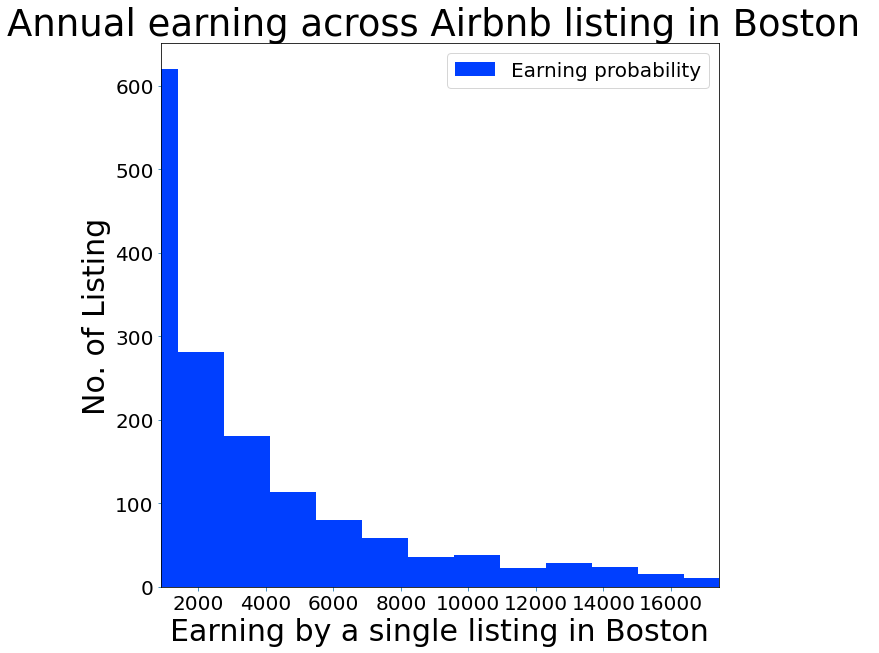

In [52]:
from plot_functions import plot_graph
from functions import range_without_outliers
inputs= {
    'title':f'Annual earning across Airbnb listing in {city} ',
    'kind' : 'hist',
    'bins' : 600,
    'x_label' : 'Earning by a single listing in Boston',
    'y_label': "No. of Listing", 
    'labelsize': 20,
    'fontsize' : 30,
    'xlim':range_without_outliers(data['annual_earnings'][data['annual_earnings']!=0]),
    'legendlabel':'Earning probability',
    'legendsize':20,
    'file_': 'results/average_earning.jpg',
}

plot_graph(data['annual_earnings'][data['annual_earnings']!=0].values, **inputs)
1

1

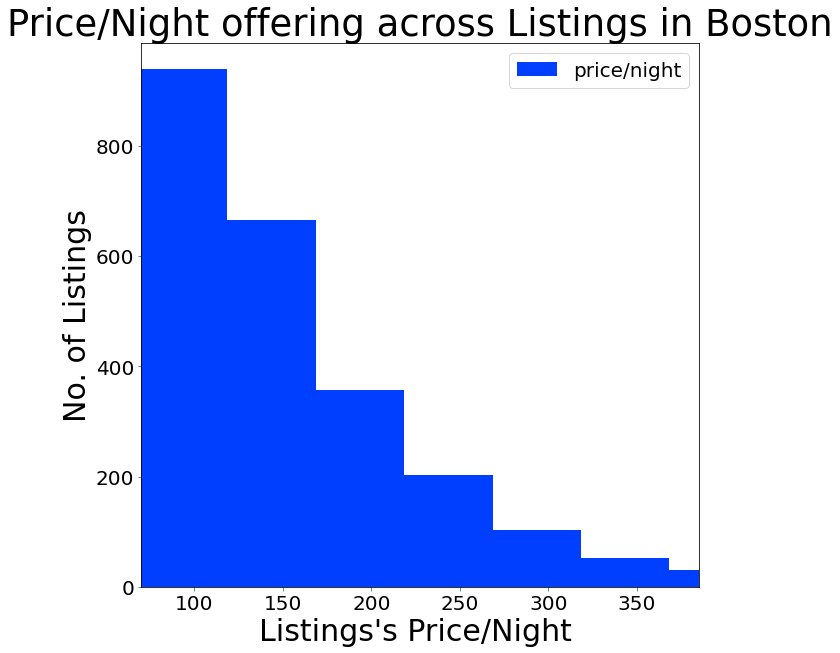

In [53]:
from plot_functions import plot_graph
from functions import range_without_outliers
inputs= {
    'title': f'Price/Night offering across Listings in {city}',
    'kind' : 'hist',
    'bins' : 200,
    'x_label' : f"Listings's Price/Night ",
    'y_label': "No. of Listings", 
    'labelsize': 20,
    'fontsize' : 30,
    'xlim':range_without_outliers(data['price']),
    'legendlabel':'price/night',
    'legendsize':20,
    'file_': 'results/price_options.jpg'
}
plot_graph(data['price'].values, **inputs)
1

In [54]:
data['annual_earnings'].mean()

4178.910636982066

Price with highest demand = $124


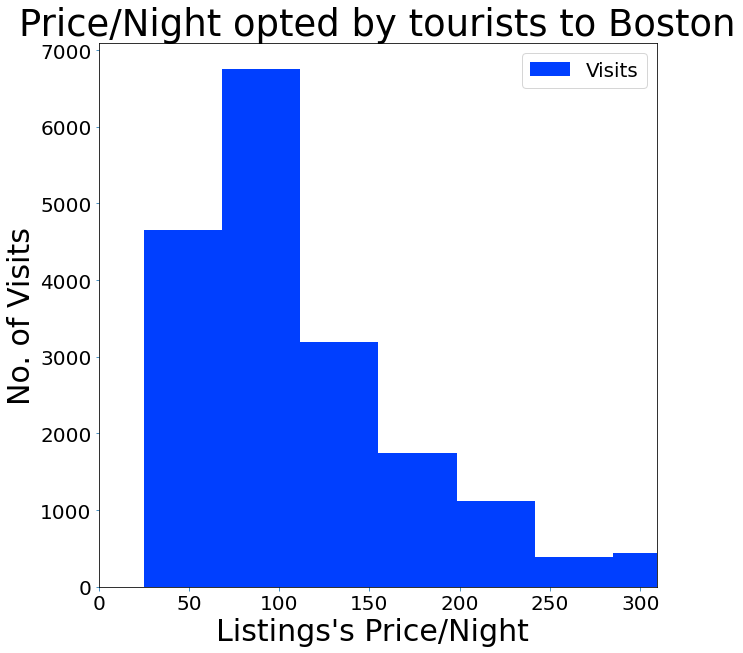

In [55]:
def price_demand(df):
  ans=list()
  tmp=data[['price','number_of_reviews_ltm']].apply(
      lambda col: [col['price']]*int(col['number_of_reviews_ltm']),axis=1 )
  for i in tmp:
    ans.extend(i)
  return pd.Series(ans)
inputs= {
    'title': f'Price/Night opted by tourists to {city}',
    'kind' : 'hist',
    'bins' : 50,
    'x_label' : f"Listings's Price/Night ",
    'y_label': "No. of Visits", 
    'labelsize': 20,
    'fontsize' : 30,
    'xlim':[0,range_without_outliers(price_demand(data))[1]],
    'legendlabel':'Visits',
    'legendsize':20,
    'file_': 'results/price_demand.jpg'
}
plot_graph(price_demand(data).values, **inputs)
#price_demand(data).plot(kind='hist',bins=50, xlim=[0,600])
print('Price with highest demand =','$'+str(int(price_demand(data).mean()))) 

In [56]:
#let's visualize whether other factor can help to increase earning other than price/night

1

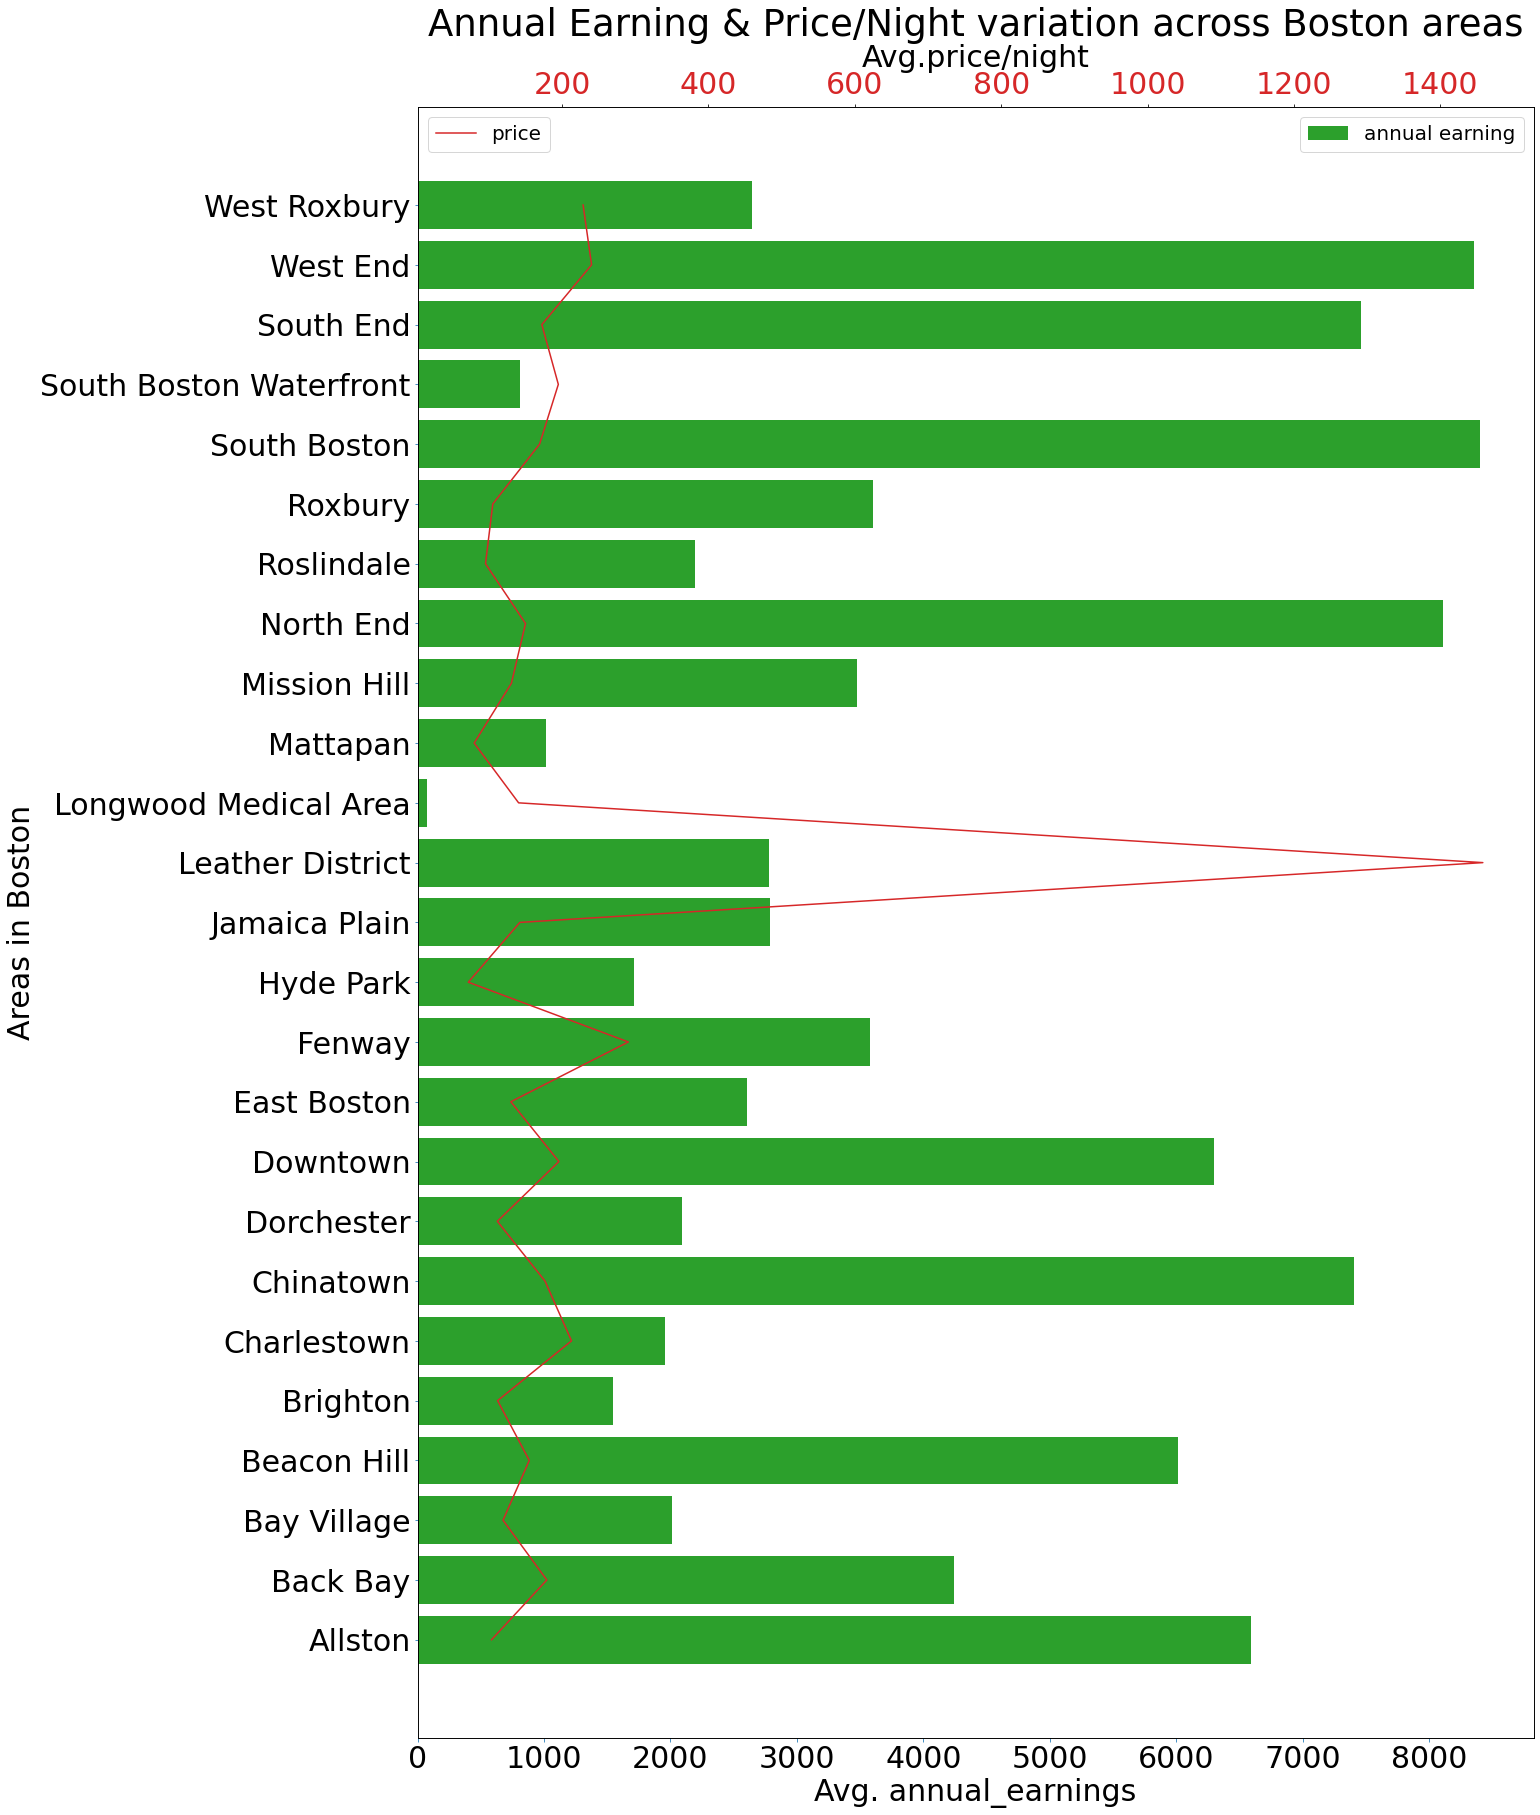

In [57]:
#results3 : Variation of avg.price & annual_earning across areas
from plot_functions import plot_graph_doubleX
tmp1=data[['neighbourhood_cleansed',
     'annual_earnings']].groupby(['neighbourhood_cleansed']).mean()
tmp2=data[['neighbourhood_cleansed',
     'price']].groupby(['neighbourhood_cleansed']).mean()
inputs={
    'title':'Annual Earning & Price/Night variation across Boston areas',
    'x_label':'Avg. annual_earnings',
    'y_label':'Areas in Boston',
    'kind':'barh',
    'x_label2': 'Avg.price/night',
    'figWidth':20,
    'figHeight':30,
    'labelsize':30,
    'fontsize':30,
    'legendsize':20,
    'legendlabel':'annual earning',
    'legendlabel2': 'price',
    'file_': 'results/earning_distribution.jpg'
    }
plot_graph_doubleX([tmp1.index.values,tmp1.values.flatten()],
          [tmp2.values.flatten(),tmp2.index.values,], 
           **inputs)
1

In [58]:
#since price parameter's impact has already been accounted,
#then other parameter's impact has to measured on no.of visits.

1

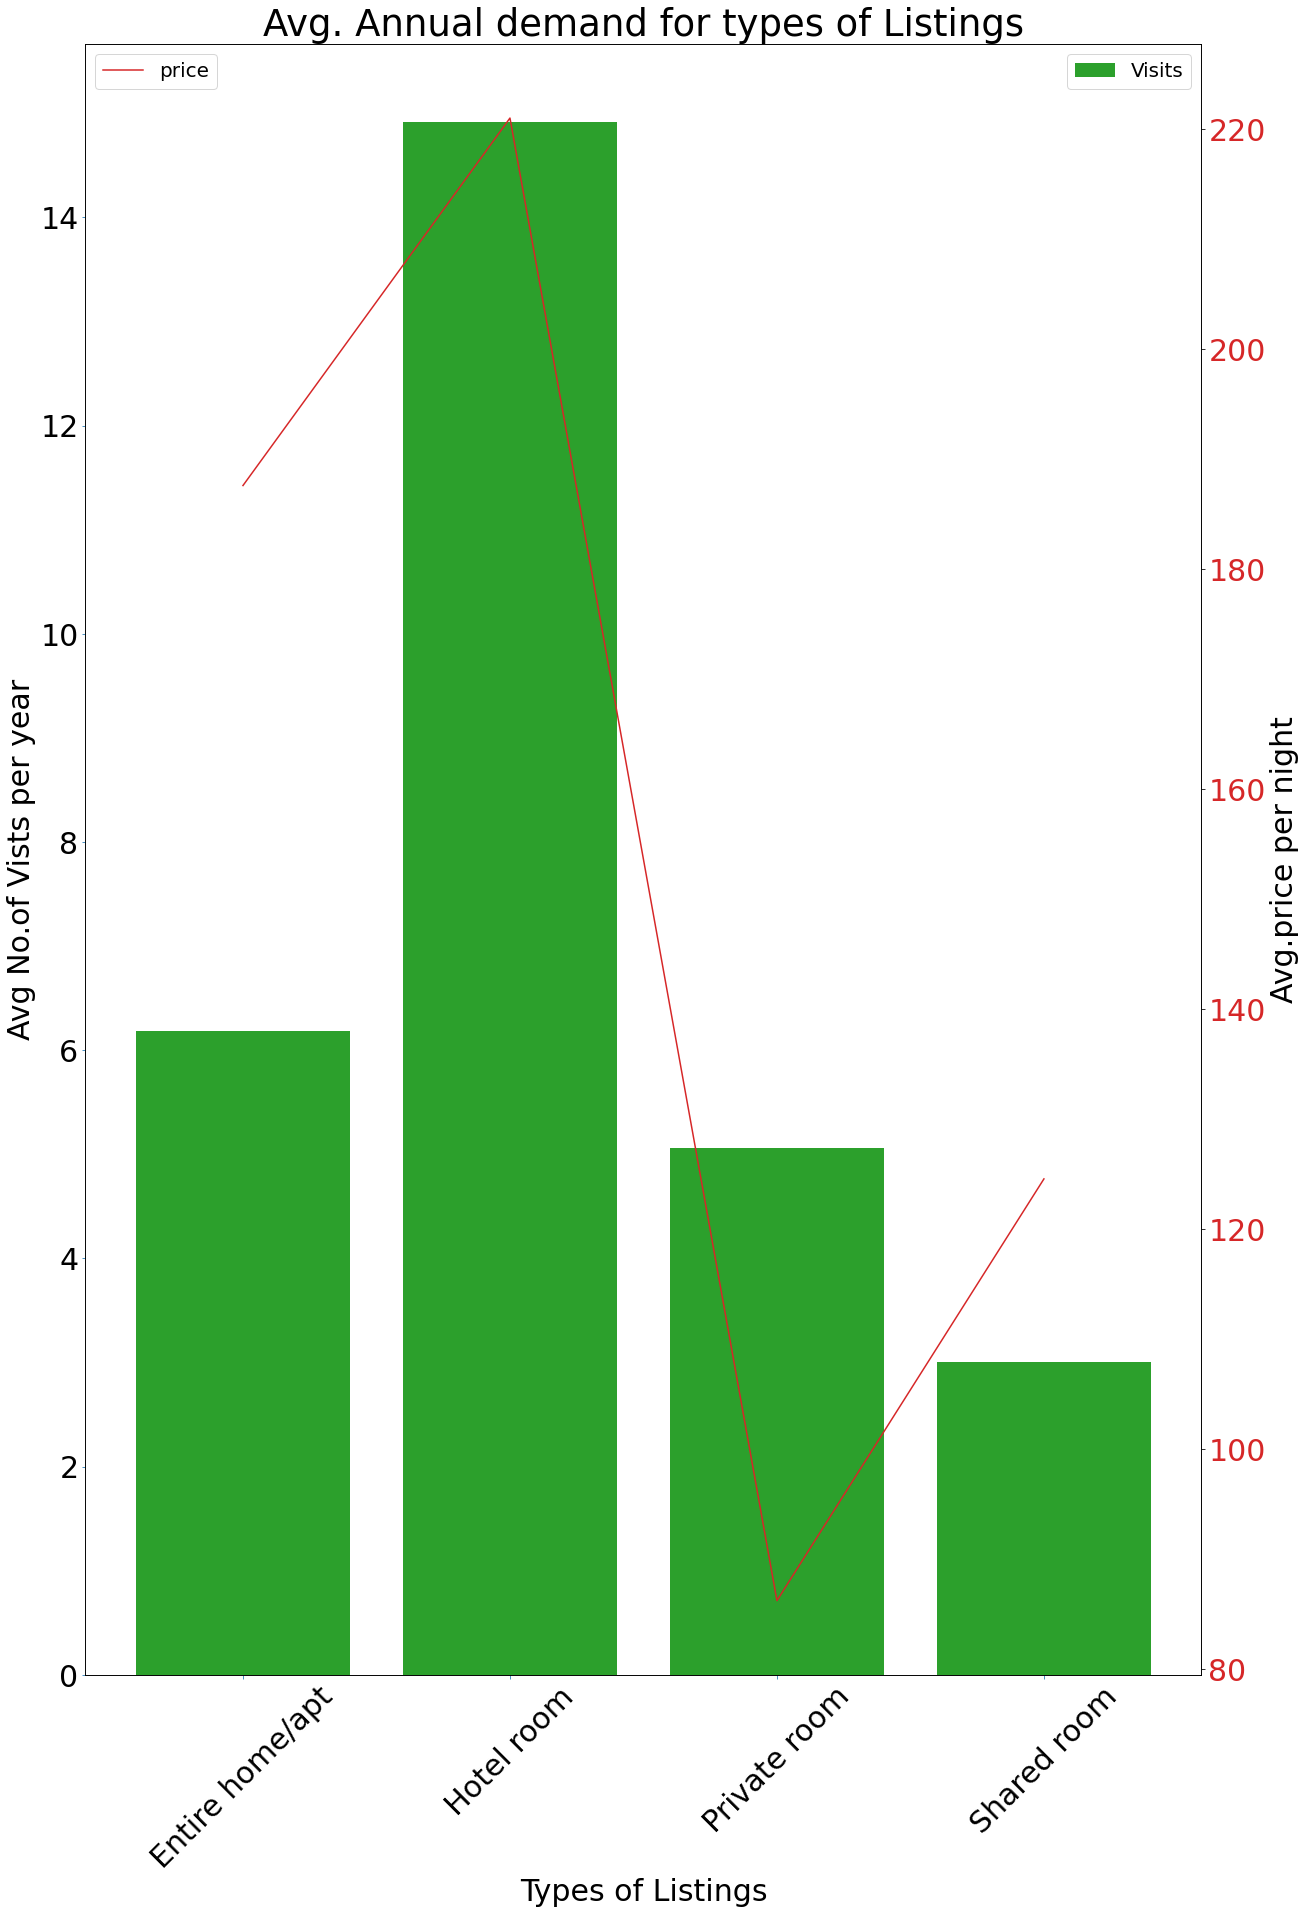

In [59]:
#results4 : Demand against different types of listings
from plot_functions import plot_graph_doubleY
from clean_data import categorical_values_rooms
from functions import reverse_dict,category_from_encoding
categories=reverse_dict(categorical_values_rooms(None,get_encoding=True))
tmp=data[['number_of_reviews_ltm','room_type','price']]
tmp=tmp.apply(lambda col : col.apply(category_from_encoding,args=(categories,))\
                     if col.name=='room_type' else col)
tmp1=tmp[['number_of_reviews_ltm','room_type']].groupby(['room_type']).mean()
tmp2=tmp[['price','room_type']].groupby(['room_type']).mean()
inputs={
    'title':'Avg. Annual demand for types of Listings',
    'y_label':'Avg No.of Vists per year',
    'x_label':'Types of Listings',
    'kind':'bar',
    'y_label2': 'Avg.price per night',
    'figWidth':20,
    'figHeight':30,
    'labelsize':30,
    'fontsize':30,
    'legendsize':20,
    'legendlabel':'Visits',
    'legendlabel2': 'price',
    'xlabelrotation':45,
    'file_': 'results/categorical_demand.jpg'
    }
plot_graph_doubleY([tmp1.index.values,tmp1.values.flatten()],
          [tmp2.index.values,tmp2.values.flatten()], 
           **inputs)
1

In [60]:
#Evaluate whether other parameters have impact on visits 

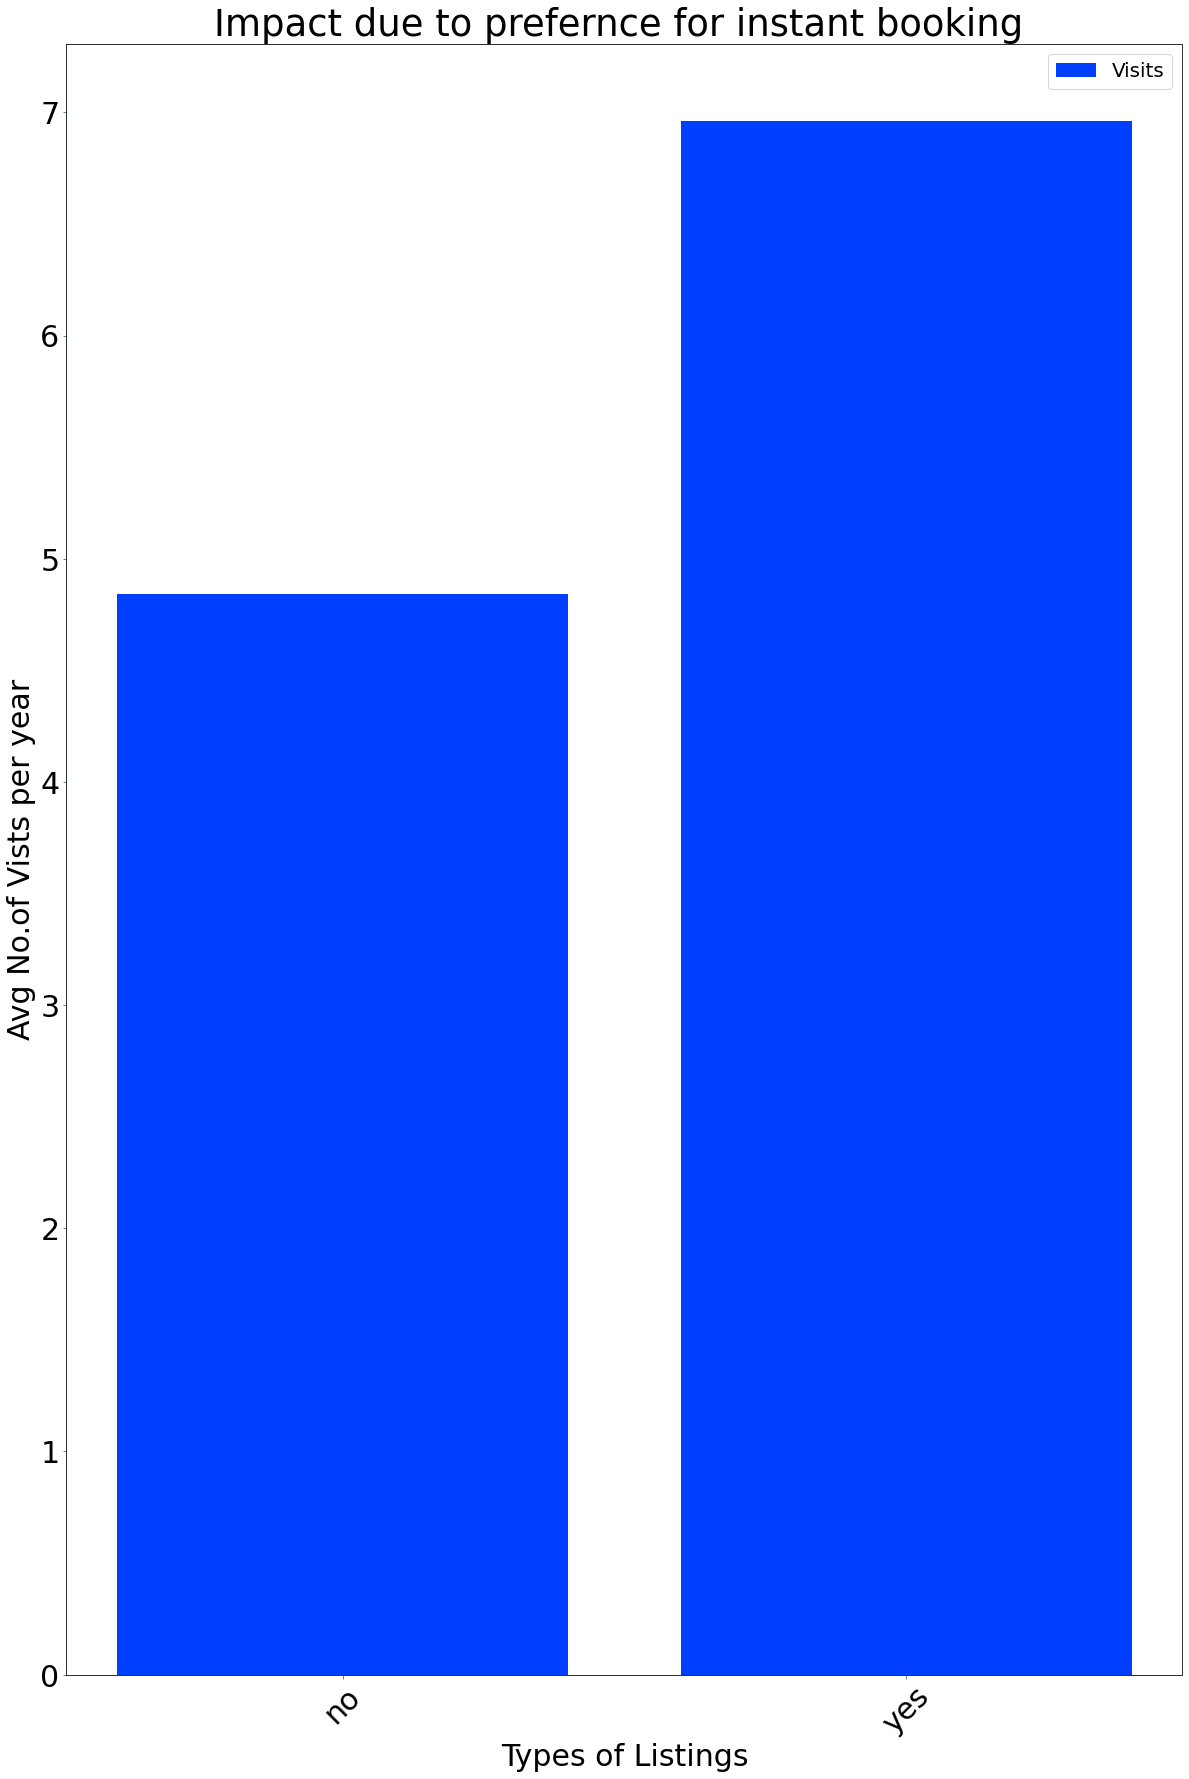

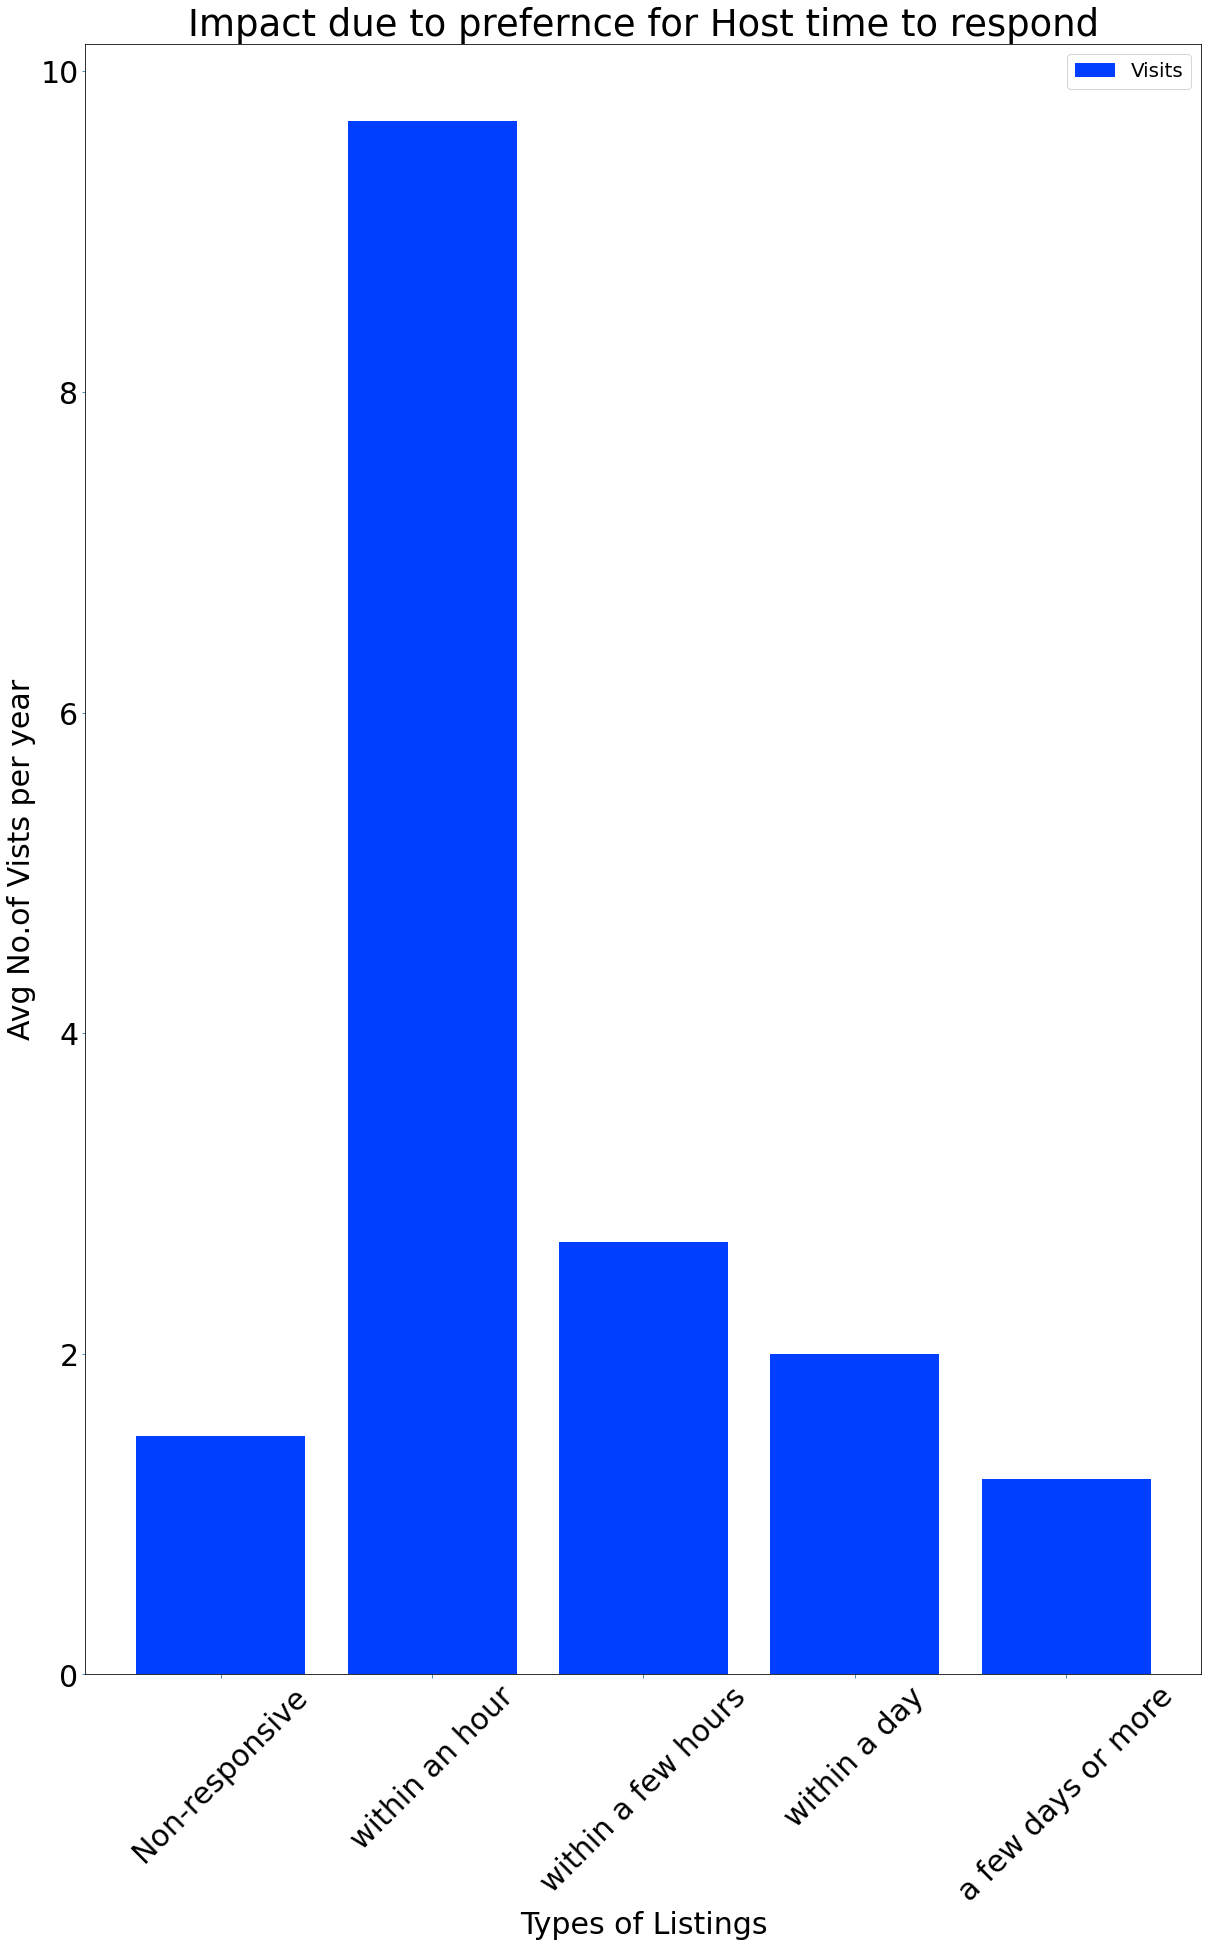

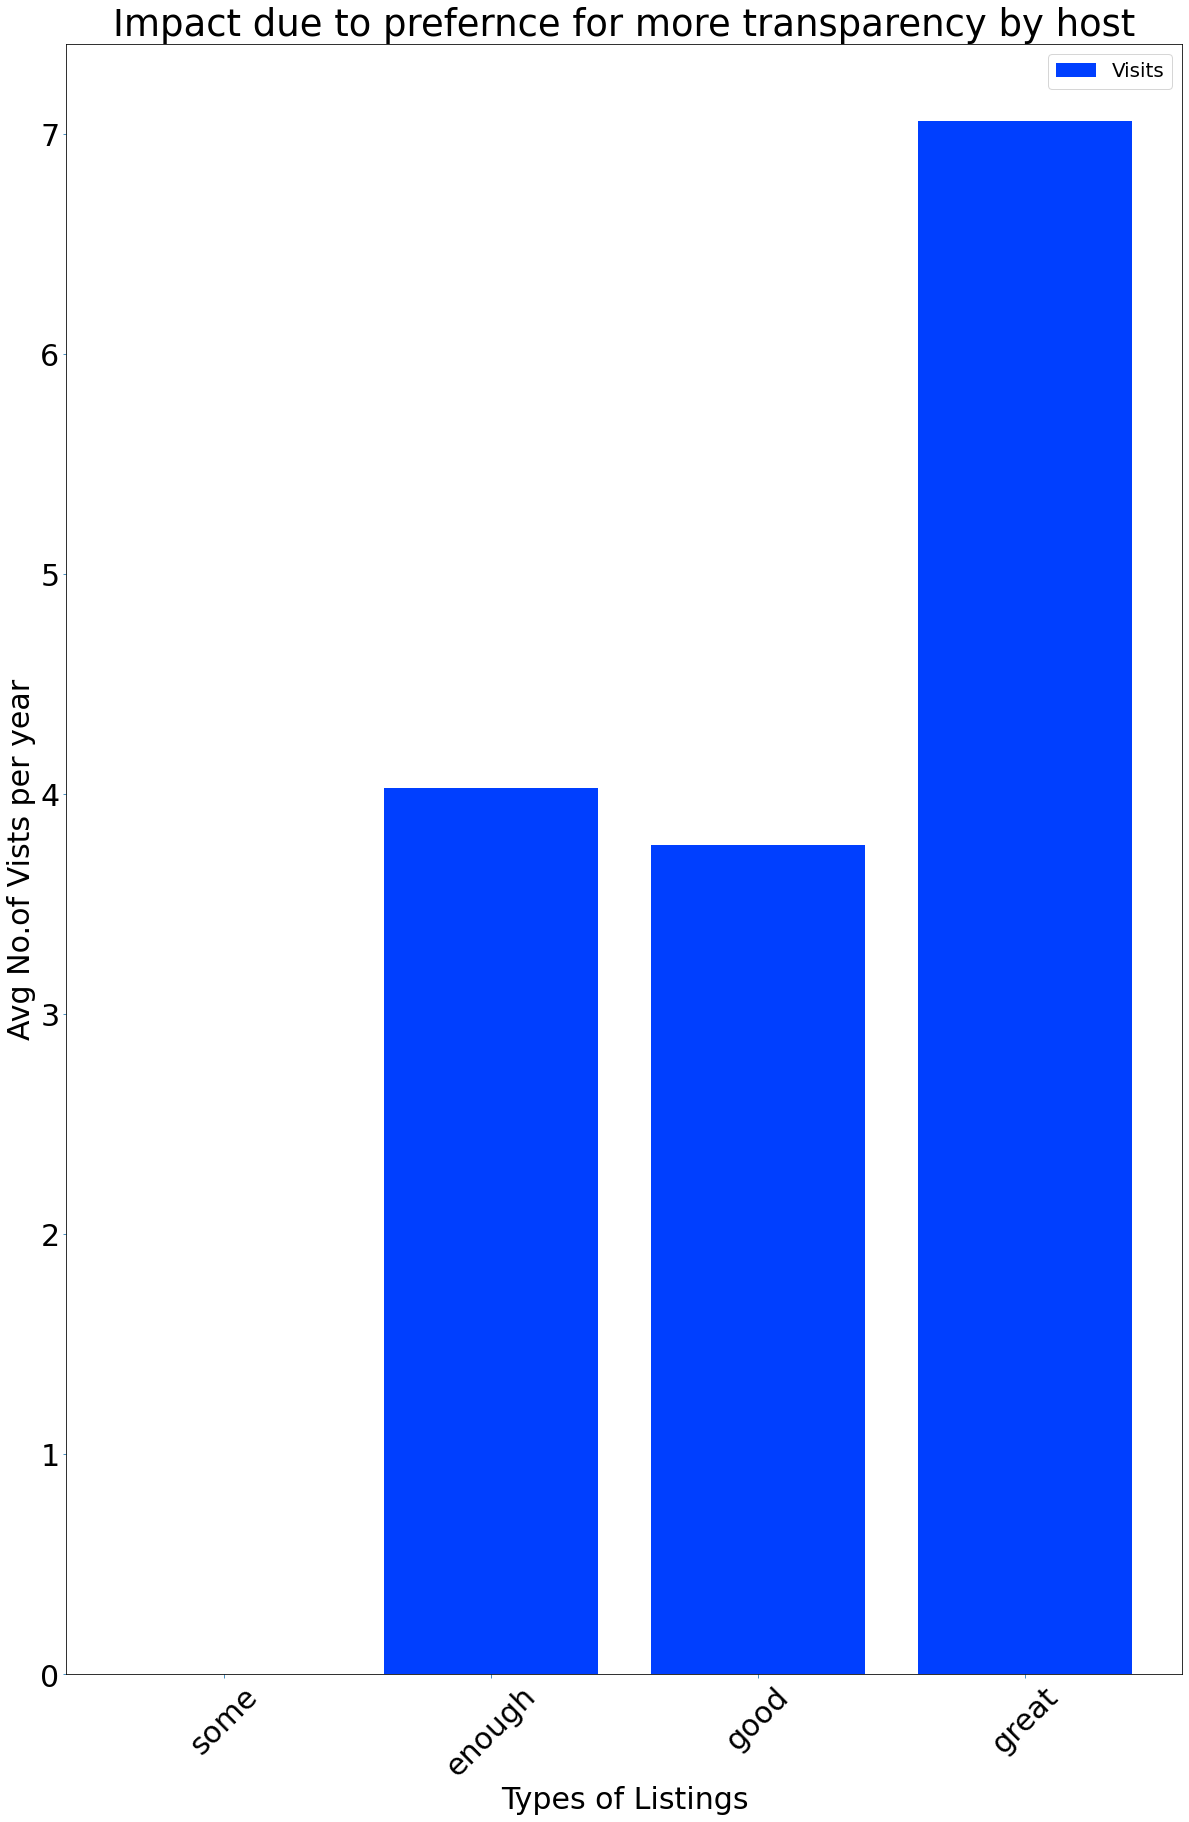

In [61]:
#results5 : Impact on vists from other parameters
cols=['instant_bookable','host_response_time',
    'host_descriptions',]
from plot_functions import plot_graph
tmp=data[cols+['number_of_reviews_ltm']]
labels={
    'instant_bookable' : {1:"yes",0:'no'},
    'host_response_time': {24:'within a day' ,  
                           8:'within a few hours' , 
                           1:'within an hour' ,
                           24*3:'a few days or more',
                           0: 'Non-responsive'}, 
    'host_descriptions':{6:'some',7:'enough',8:'good',9:'great'},
}
props={
    'instant_bookable': ['instant booking ','instant_impact.jpg' ],
    'host_response_time':['Host time to respond','host_response.jpg'],
    'host_descriptions':['more transparency by host','host_descriptions.jpg'],
}
for col in cols:
    p=tmp[[col,'number_of_reviews_ltm']].groupby(col).mean()
    inputs={
        'title':f'Impact due to prefernce for {props[col][0]}',
        'y_label':'Avg No.of Vists per year',
        'x_label':'Types of Listings',
        'kind':'bar',
        'figWidth':20,
        'figHeight':30,
        'labelsize':30,
        'fontsize':30,
        'legendsize':20,
        'legendlabel':'Visits',
        'xlabelrotation':45,
        'file_': f'results/{props[col][1]}',
    }
    plot_graph(list(map(lambda x : labels[col][x],p.index.values)),
                    p.values.flatten(),**inputs)
    1

In [62]:
#also evaluate whether these parameters are mutually indepedent or they impact each other 

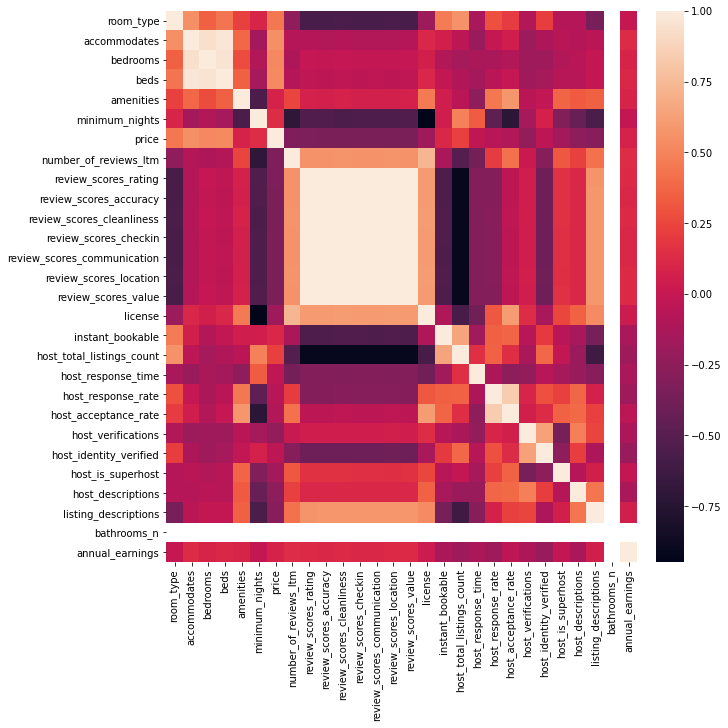

In [63]:
#quick peak in correlation among other variables
inputs={
    'file_' : 'results/heatmap.jpg'
}
from plot_functions import plot_variable_corelation
plot_variable_corelation(data.corr(),**inputs)

In [64]:
#Also inspect whether these parameters have seasonality impact or not 
#that is to say whether the demand stays consistent throughout the year

1

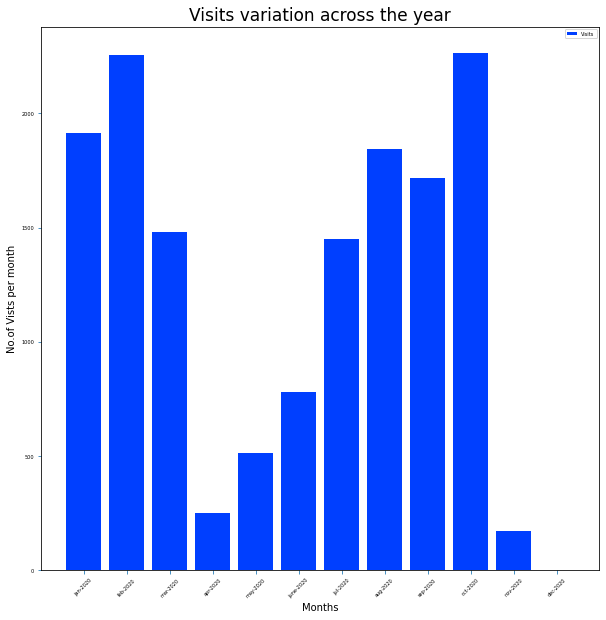

In [65]:
#results6 : seasonality check
import pandas as pd
from clean_data import clean_preprocess_reviews
reviews=clean_preprocess_reviews(reviews)
labels=['jan-2020','feb-2020','mar-2020','apr-2020','may-2020',
        'june-2020','jul-2020','aug-2020','sep-2020','oct-2020',
        'nov-2020','dec-2020']
bins=list(map(lambda x : pd.to_datetime(x),labels+['Jan-2021']))
tmp=reviews.groupby(pd.cut(
                    reviews['date'],
                    bins=bins,
                    labels=labels))['date'].count()
inputs={
        'title':'Visits variation across the year',
        'y_label':'No.of Vists per month',
        'x_label':'Months',
        'kind':'bar',
        'figWidth':10,
        'figHeight':10,
        'labelsize':5,
        'fontsize':10,
        'legendsize':5,
        'legendlabel':'Visits',
        'xlabelrotation':45,
        'file_': 'results/monthly_visits.jpg',
    }
plot_graph(list(tmp.index.values),
                    tmp.values.flatten(),**inputs)
1

In [66]:
#so let's find out whether which parameter has how much impact on visits

In [67]:
#Here simple linear model is assumed to find the impact of the parameters

test rms_error =  13.47076455182746


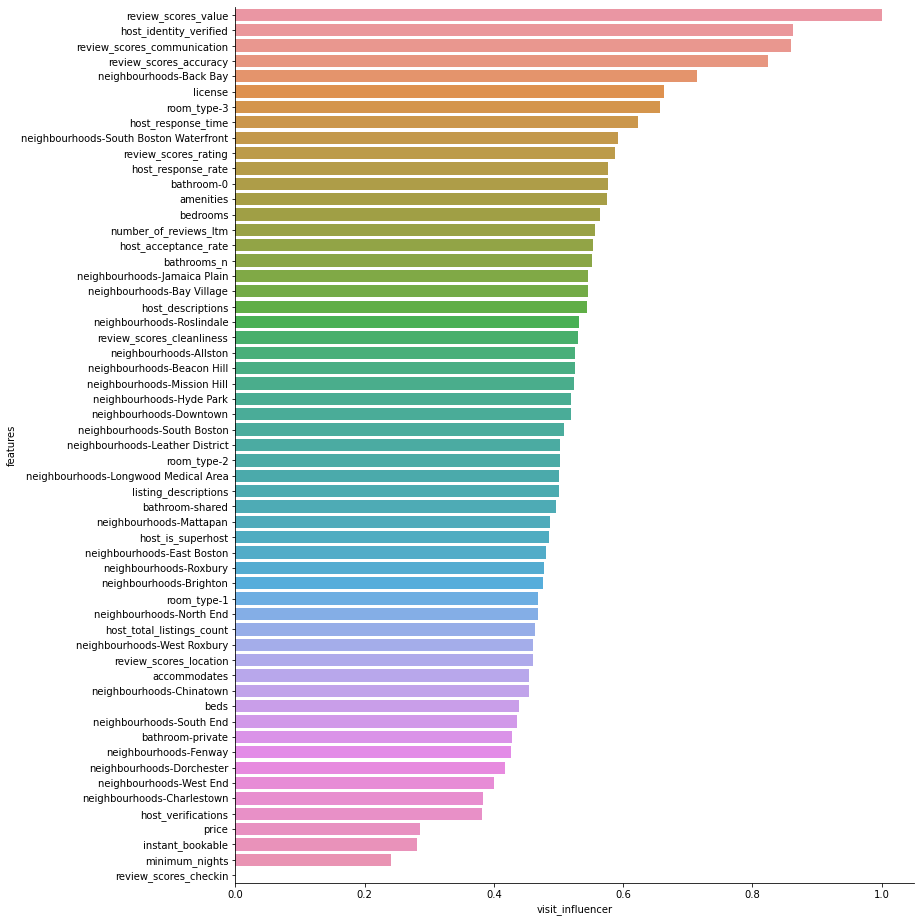

In [68]:
#results7: Finding top 3 impact creating explanatory variables
from model_functions import model
from functions import subtract_elem
import pandas as pd
from plot_functions import plot_coeff
tmp=data.drop(columns=['annual_earnings'])
tmp=pd.get_dummies(tmp,columns=['neighbourhood_cleansed','bathrooms_type',
                                'room_type'],
                            prefix=['neighbourhoods','bathroom','room_type'],
                            prefix_sep='-')
outcomes=['number_of_reviews_ltm']
variables=subtract_elem(tmp.columns,outcomes)
model.set_inputs(data=tmp,
                outcomes=outcomes,
                variables=variables)
model.train()
#model trained & plotting results
ans=model.model.model.named_steps.regressor.coef_
ans=ans.ravel()
order=ans.argsort()[::-1]
tmp=pd.concat([pd.Series(tmp.columns[order]),
                pd.Series(ans[order])], 
                axis=1,).\
                    rename(columns={0:'features',1:'visit_influencer'})
inputs={
    'file_':'results/top3.jpg',
    'show': False,
   'x':'visit_influencer',  
   'y':'features',
    'scale' : ['visit_influencer'],
    'height':5*2.54,
}
plot_coeff(tmp,**inputs)

In [69]:
#the complete above process has been compiled into one python script 
#running the complete process in one step
%%time
!python main.py

cleaning and preprocessing the data
Plotting the results
The average earning among the listings in Boston is  4178  in US-Dollars
The average price/night for a visitor in Boston based on available listings is  152  in US-Dollars
Price with highest demand = $124
Building the model
Training the the model
test rms_error =  13.47076455182746
plotting the results from the trained model 
Complete program has been successfull executed
All the plot results have been created in the path results/
CPU times: user 311 ms, sys: 52.1 ms, total: 363 ms
Wall time: 2min 1s
